In [ ]:
from IPython.core.display import Image, display

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm


# Modern Theory of Detection and Estimation
### Fall 2020 Project
Alejandro Martín de Fuentes Iglesias (100362408) 

Iosif Mondoc (100384001)

Patricia Paredes Martín (100384122)
&nbsp;
&nbsp;
&nbsp;
#Machine Learning for Regression

&nbsp;
&nbsp;
&nbsp;

Dept. of Signal Processing and Communications



# Diabetes dataset

[Diabetes](https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset) is another classic benchmark for regression. Each observation corresponds to a diabetes patient represented by 10 variables and the corresponding target is a score that measures  the disease progression one year after baseline.

The variables that form each observation are:
- age in years

- sex

- bmi body mass index

- bp average blood pressure

- six measures taken from the blood of the patient:
  - s1 tc, T-Cells (a type of white blood cells)

  - s2 ldl, low-density lipoproteins

  - s3 hdl, high-density lipoproteins

  - s4 tch, thyroid stimulating hormone

  - s5 ltg, lamotrigine

  - s6 glu, blood sugar level

The dataset is available in sklearn through [load_diabetes](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes). Take a moment to read the documentation...

Next cell loads the data for you and create the train and test partitions (80-20%, respectively) that we are going to use along this notebook.


In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

data = load_diabetes()
feature_names = data['feature_names'] # list with feature names

X = data['data']
Y = data['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("{0:d} train observations with {1:d} columns".format(X_train.shape[0], X_train.shape[1]))
print("{0:d} train targets".format(len(X_train)))

print("{0:d} test observations with {1:d} columns".format(X_test.shape[0], X_test.shape[1]))
print("{0:d} test targets".format(len(X_test)))

353 train observations with 10 columns
353 train targets
89 test observations with 10 columns
89 test targets


Once the data set is loaded, analyze the observation matrix X (calculate the mean and standard deviation of your variables) and justify the need or not to normalize the data. If you consider that normalization is necessary, normalize the data in the next cell.


In [ ]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()   #Creamos el objeto para hacer el csmbio

X_train_s = np.array(scaler.fit_transform(X_train))   #Fit to data, then transform it.
X_test_s = np.array(scaler.transform(X_test))
#Son gasussianas practicamente con media = 0 y una deviación X
#creo que la media es entorno a 10^-4 y la desviación 10^-2
#NO HACE FALTA NORMALIZAR

print("Mean of X_train")
print(np.mean(X_train,0))    
print("")
print("Mean of X_train_s (normalized)")
print(np.mean(X_train_s,0))
print("")
print("Mean of X_test")
print(np.mean(X_test,0))
print("")
print("Mean of X_test_s (normalized)")
print(np.mean(X_test_s,0))
print("")
#No será necesario normalizar los datos porque como se puede ver en el X_train sin normailzar la
#media de los datos ya es practicamente 0 en todas sus columnas.

Mean of X_train
[ 0.00144181  0.00018389  0.00173566  0.00117937 -0.00055551 -0.00080601
 -0.000989    0.00037655  0.001216    0.00189101]

Mean of X_train_s (normalized)
[-3.89993357e-17 -1.13852899e-16 -9.43532316e-18 -6.68335390e-17
  6.10150897e-17 -1.85561355e-17 -1.48449084e-16  2.01915916e-16
 -1.90279017e-17  8.30701576e-17]

Mean of X_test
[-0.00571863 -0.00072937 -0.00688413 -0.00467772  0.00220332  0.00319687
  0.00392268 -0.00149352 -0.00482303 -0.00750029]

Mean of X_test_s (normalized)
[-0.15475875 -0.0191956  -0.18259061 -0.12101417  0.0578151   0.08415825
  0.10455509 -0.03918665 -0.12644437 -0.19438961]



# 1. Evaluation of regression methods



The methods you will explore to solve this task are:
- [Regularized linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) 
- [Kernel ridge regression with an RBF kernel](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)
- [Random Forests for regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- [$k$NN for regression](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor



### Measure performance: $R^2$ score 

In sklearn regression the *score* by default is the  $R^2$ statistic.
$$
R^2 = 1-\frac{\sum_{i=1}^{N_t}{(y_i-\hat{y}_i)^2}}{\sum_{i=1}^{N_t}{(y_i-\bar{y})^2}}
$$where $N_t$ is the length of the evaluation set, $\hat{y}_i$, $i=1,\dots,N_t$ are the estimations made by the model, $y_i$ ($i=1,\dots,N_t$)  are the true targets of the evaluation set and $\bar{y}=1/N_t\sum_{i=1}^{N_t}y_i$ is its average.

**$R^2$ interpretation**

$R^2$ takes a maximum value of $1.0$ when the model makes an exact  (0 error) estimation of all the targets. The value of $R^2$ decreases as the estimation errors increase. 

The decrease in $R^2$ value is determined by the comparison between the accuracy of the model in the test set and that of a trivial model that would output as estimation for all the targets their mean value. 

If the model is not perfect ($R^2=0$) but better than the trivial one, then $0 < R^2 < 1$. If $R^2$ falls below 0 and takes negative values, it means that the estimations output by the model are worse than using the mean (trivial estimation). 

 

## 1.1. Selection of hyperparameters for all the regression methods under study

The first task is to obtain a reasonable set of hyperparameters for all the methods. In this assignment the corresponding ranges will be:
- Linear Ridge Regression:
  - `alpha`: 0.0001, 0.001, 0.01, 0.1, 1
- Kernel Ridge Regression:
  - `alpha`: 0.0001, 0.001, 0.01, 0.1, 1
  - `gamma` for the RBF kernel: 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1
- Random Forests:
  - number of estimators: 10, 20, 50, 100, 200, 500, 1000
  - maximum number of leaves per tree: 5, 10, 20, 50
- $k$NN:
  - $k$: 1,2,3,5,7,10,15,20,40, 80
  - weight: uniform and distance


*Note*: In class the ridge regressor model had a regularization parameter called $\lambda$. As $\lambda$ is a reserved word in Python, sklearn has called this parameter as `alpha`.


### 1.1.1 Program the grid exploration
The next cell contains the skeleton of the code to construct a GridSearch and performs its exploration with a 10 fold cross validation.

Complete the missing lines.

In [ ]:
def my_grid(model, parameters, X_train, Y_train, X_test, Y_test):

  grid = GridSearchCV(model(), parameters, cv=10)
  grid.fit(X_train, Y_train)
  r2_value = grid.score(X_test,Y_test) 
  model_best_params = grid.best_params_
  return grid, r2_value, model_best_params

### 1.1.2 Crossvalidate the model parameters 

Now use the function above to find hyperparameters for Random Forest, kNN, ridge regression and kernel ridge regression. Return the values od the selected parameters for each model.

Hint: remember the grid can store a best estimator


### K-NN

In [ ]:

grid_paramsKNN = {
    'n_neighbors' :  [1, 3, 5, 7, 10, 15, 20, 40, 80],
    'weights' : ['uniform','distance']
}

gridKNN, r2_valueKNN, KNN_best_params = my_grid(KNeighborsRegressor,grid_paramsKNN,X_train, Y_train, X_test, Y_test)
print("Error cuadrático medio:")
print(r2_valueKNN)
print("")
print("Mejores hyperparametros:")
print(KNN_best_params)

Error cuadrático medio:
0.43452846638964693

Mejores hyperparametros:
{'n_neighbors': 20, 'weights': 'distance'}


### Random Forest

In [ ]:
grid_paramsRF = {
    'n_estimators' : [10, 20, 50, 100, 200, 500, 1000],
    'max_leaf_nodes' : [5, 10, 20, 50] 
}

gridRF, r2_valueRF,RF_best_params = my_grid(RandomForestRegressor,grid_paramsRF,X_train, Y_train, X_test, Y_test)
print("Error cuadrático medio:")
print(r2_valueRF)
print("")
print("Mejores hyperparametros:")
print(RF_best_params)

Error cuadrático medio:
0.4621151245827566

Mejores hyperparametros:
{'max_leaf_nodes': 20, 'n_estimators': 100}


### Ridge Regression

In [ ]:
grid_paramsRR = {
'alpha' : [0.0001, 0.001, 0.01, 0.1, 1]
}
gridRR, r2_valueRR,RR_best_params = my_grid(Ridge,grid_paramsRR,X_train, Y_train, X_test, Y_test)
print("Error cuadrático medio:")
print(r2_valueRR)
print("")
print("Mejores hyperparametros:")
print(RR_best_params)

Error cuadrático medio:
0.4608531678297328

Mejores hyperparametros:
{'alpha': 0.1}


### Kernel Ridge Regression

In [ ]:
grid_paramsKRR = {
'alpha' : [0.0001, 0.001, 0.01, 0.1, 1],
'kernel' : ['rbf'],
'gamma' : [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
}
gridKRR, r2_valueKRR, KRR_best_params = my_grid(KernelRidge,grid_paramsKRR,X_train, Y_train, X_test, Y_test)
print("Error cuadrático medio:")
print(r2_valueKRR)
print("")
print("Mejores hyperparametros:")
print(KRR_best_params)

Error cuadrático medio:
0.4613522704926605

Mejores hyperparametros:
{'alpha': 0.01, 'gamma': 0.05, 'kernel': 'rbf'}


### 1.1.3 Discussion

Analyze which method is better than the others in terms of $R^2$ score.



**El mejor hyperparametro en cuanto a R2 es kernel Ridge seguido muy de cerca por ridge. Pese a ello el tiempo de ejecución hace pensar que el mejor algoritmo en general es Ridge Regression ya que tarda aprox 1/4 menos en tiempo de ejecucion que kernel Ridge.**



## 1.2. Measures of training and evaluation time





### 1.2.1. Compute time and test times

Use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) to obtain estimations of the **time needed to train each method** and the **time needed to evaluate a test set**. Select 10 folds to express the measures with mean and standard deviations.  **Use the best set of hyperparameters in terms of $R^2$ found in the previous cell**. 

In [ ]:
from sklearn.model_selection import  cross_validate

bestKNN= KNeighborsRegressor( n_neighbors = 20, weights = 'distance')
bestKNN.fit(X_train, Y_train)
cv_resultsKNN = cross_validate(bestKNN, X_test, Y_test, cv=10)
print("KNN TIMES:")
print('SCORE TIMES')
score_timeKNN= cv_resultsKNN['score_time']
print(cv_resultsKNN['score_time'])
print('La media es: ', np.mean(score_timeKNN))
print('La deviacion tipica es', np.std(score_timeKNN))
print('')
cv_resultsKNN2 = cross_validate(bestKNN, X_train, Y_train, cv=10)
print('TIME FIT')
time_fitKNN = cv_resultsKNN2['fit_time']
print(cv_resultsKNN2['fit_time'])
print('La media es: ', np.mean(time_fitKNN))
print('La deviacion tipica es', np.std(time_fitKNN))
print("")
print("")

#RANDOM FOREST
bestRF= RandomForestRegressor( max_leaf_nodes = 20, n_estimators = 50)
bestRF.fit(X_train, Y_train)
cv_resultsRF = cross_validate(bestRF, X_test, Y_test, cv=10)
print("RF TIMES:")
print('SCORE TIMES')
score_timeRF= cv_resultsRF['score_time']
print(cv_resultsRF['score_time'])
print('La media es: ', np.mean(score_timeRF))
print('La deviacion tipica es', np.std(score_timeRF))
print('')
cv_resultsRF2 = cross_validate(bestRF, X_train, Y_train, cv=10)
print('TIME FIT')
time_fitRF = cv_resultsRF2['fit_time']
print(cv_resultsRF2['fit_time'])
print('La media es: ', np.mean(time_fitRF))
print('La deviacion tipica es', np.std(time_fitRF))
print("")
print("")

#Ridge Regression
bestRR= Ridge( alpha = 0.1)
bestRR.fit(X_train, Y_train)
cv_resultsRR = cross_validate(bestRR, X_test, Y_test, cv=10)
print("RIDGE TIMES:")
print('SCORE TIMES')
score_timeRR= cv_resultsRR['score_time']
print(cv_resultsRR['score_time'])
print('La media es: ', np.mean(score_timeRR))
print('La deviacion tipica es', np.std(score_timeRR))
print('')
cv_resultsRR2 = cross_validate(bestRR, X_train, Y_train, cv=10)
print('TIME FIT')
time_fitRR = cv_resultsRR2['fit_time']
print(cv_resultsRR2['fit_time'])
print('La media es: ', np.mean(time_fitRR))
print('La deviacion tipica es', np.std(time_fitRR))
print("")
print("")

#Kernel Ridge Regression
bestKRR= KernelRidge( alpha = 0.01,kernel = 'rbf' ,gamma = 0.05)
bestKRR.fit(X_train, Y_train)
cv_resultsKRR = cross_validate(bestKRR, X_test, Y_test, cv=10)
print("KERNEL RIDGE TIMES:")
print('SCORE TIMES')
score_timeKRR= cv_resultsKRR['score_time']
print(cv_resultsKRR['score_time'])
print('La media es: ', np.mean(score_timeKRR))
print('La deviacion tipica es', np.std(score_timeKRR))
print('')
cv_resultsKRR2 = cross_validate(bestKRR, X_train, Y_train, cv=10)
print('TIME FIT')
time_fitKRR = cv_resultsKRR2['fit_time']
print(cv_resultsKRR2['fit_time'])
print('La media es: ', np.mean(time_fitKRR))
print('La deviacion tipica es', np.std(time_fitKRR))


#El orden de menor a mayor de score time(test) es:
#Ridge, Kernel Ridge, kNN, Random forest
#El orden de menor a mayor de time fit(train) es:
#kNN, Ridge, Kernel Ridge, Ranmdom forest (random forest tiene un aumento muy significativo respecto a los demás, 0.1s frente a 0.006 aproximadamente en los demás)

KNN TIMES:
SCORE TIMES
[0.0010891  0.00093412 0.00091004 0.00089216 0.00091529 0.00090146
 0.00089431 0.00089216 0.00088644 0.00103736]
La media es:  0.0009352445602416992
La deviacion tipica es 6.636521941956732e-05

TIME FIT
[0.0009613  0.00045896 0.00047302 0.00046587 0.00046515 0.00045657
 0.00045562 0.00050187 0.00046515 0.00046515]
La media es:  0.0005168676376342774
La deviacion tipica es 0.00014867249811755377


RF TIMES:
SCORE TIMES
[0.00343442 0.0039978  0.0033977  0.00332069 0.00334549 0.00449824
 0.00332546 0.00332189 0.00447249 0.00344944]
La media es:  0.0036563634872436523
La deviacion tipica es 0.0004561886220937472

TIME FIT
[0.09310317 0.09173942 0.09437895 0.1438849  0.09344673 0.09187531
 0.09206367 0.08978963 0.08908939 0.09485769]
La media es:  0.0974228858947754
La deviacion tipica es 0.015583793951210784


RIDGE TIMES:
SCORE TIMES
[0.0007062  0.00066042 0.00049901 0.00046325 0.00047684 0.00048614
 0.00047851 0.00050187 0.00046349 0.00045896]
La media es:  0.0005

### 1.2.2. Visual representation
Produce a (1,2) subplot with the following information:
- left panel: scatter plot of the performance of the 4 methods. The x axis is the **time to fit** and the y axis is the $R^2$. Each method should have a single marker with a different color. Use the legend to identify methods

- right panel: The x axis is the **time to score** and the y axis is the $R^2$. Each method should have a single marker with a different color. Use the legend to identify methods

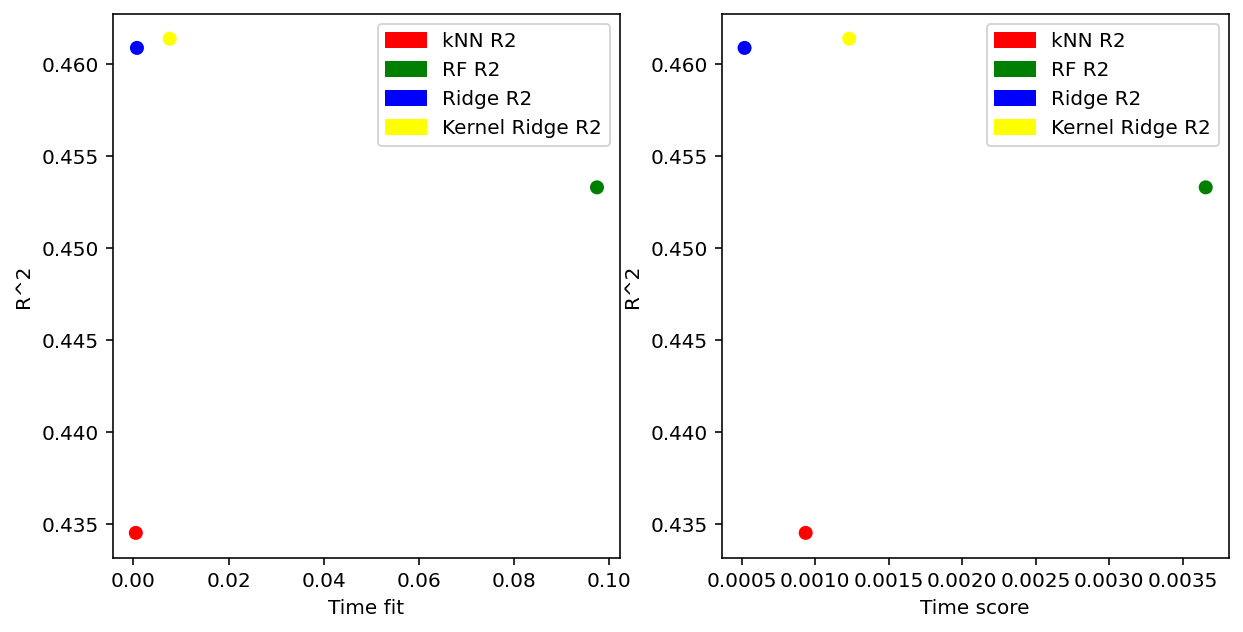

In [ ]:
import matplotlib.patches as mpatches

time_fit = [np.mean(time_fitKNN), np.mean(time_fitRF), np.mean(time_fitRR), np.mean(time_fitKRR)]
score_time = [np.mean(score_timeKNN), np.mean(score_timeRF), np.mean(score_timeRR),  np.mean(score_timeKRR)]
scores = [r2_valueKNN, r2_valueRF, r2_valueRR, r2_valueKRR]

red_patch = mpatches.Patch(color='red', label='kNN R2')
green_patch = mpatches.Patch(color='green', label='RF R2')
blue_patch = mpatches.Patch(color='blue', label='Ridge R2')
yellow_patch = mpatches.Patch(color='yellow', label='Kernel Ridge R2')


plt.figure(figsize=(10,5))

ax1 = plt.subplot(1,2,1)
ax1.scatter(x = time_fit, y=scores,color=['red','green','blue','yellow'])
ax1.set_xlabel('Time fit')
ax1.set_ylabel('R^2')
plt.legend(handles=[red_patch,green_patch,blue_patch, yellow_patch])

ax2 = plt.subplot(1,2,2)
ax2.scatter(x= score_time, y= scores,color=['red','green','blue','yellow'])
ax2.set_xlabel('Time score')
ax2.set_ylabel('R^2')
plt.legend(handles=[red_patch,green_patch,blue_patch, yellow_patch])


plt.show()


### 1.2.3. Discussion

Use the plots to describe the advantages and disadvantages of each method

Lo único beneficioso que tiene kNN respecto a ridge y kernel ridge es el tiempo de time fit. Sin embargo, se compensa con el tiempo de time score y encima el R2 es muy malo en comparacion a los otros.
Random forest es el peor en tiempo y encima el 2º peor en score.
Ridge tarda un poco menos que kernel ridge en general pero tamnién tiene un poco menos de error cuadratico medio, aun así ambos son muy buenos.

# 2. Feature selection

The goal in this assignment is to learn how to use machine learning for improving our domain learning about a problem. In this case the problem is to study the dependence of the progress of diabetes with the variables that characterize each patient. You want to learn:
- if any of the variables is noisy (its presence worsens the performance of the regressors)
- if any of the variables is not relevant (its presence or absence does not affect the performance of the regressor, hence you could save resources by skipping its measure)
- if some of these variables are more critical than the others in the conformation of the score. This way you can gain insights about the main drivers of the disease.

Next sections propose you several approaches to carry out this feature selection.


## 2.1. Univariate Feature Selection


### 2.1.1. Univariate Feature Selection with linear regression

As there are 10 input variables, one can solve 10 1D problems and see what is the best variable if we had to stick to a model with a single variable. 

- Construct the 10 linear models (using a linear ridge regressor)
- Crossvalidate, with a 10 fold CV, their `alpha` parameters in the range `alpha`: 0.001, 0.01, 0.1, 1
- Plot $5\times 2$ the model with scatters, print in the title the $R^2$

Which variable is more critical to predict the disease progression?

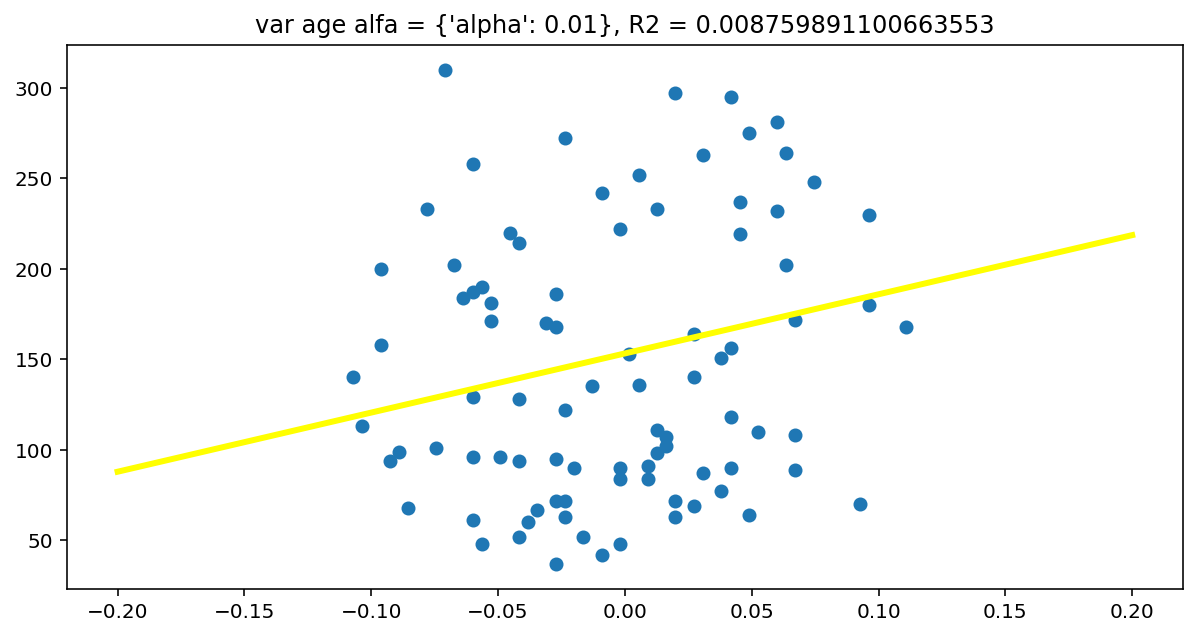

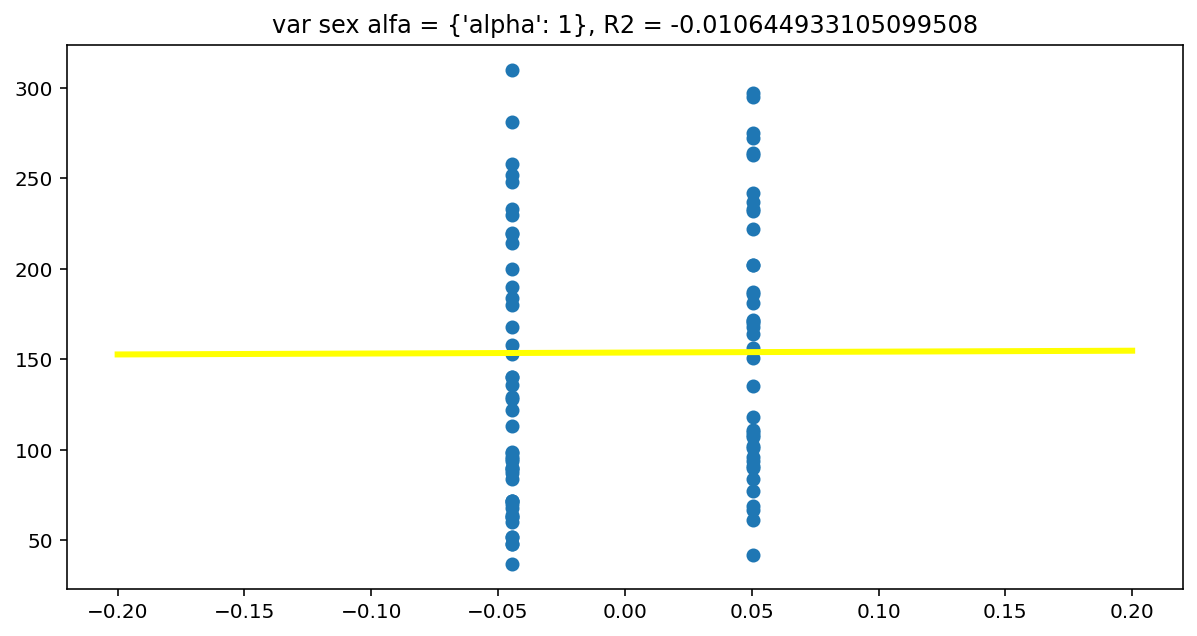

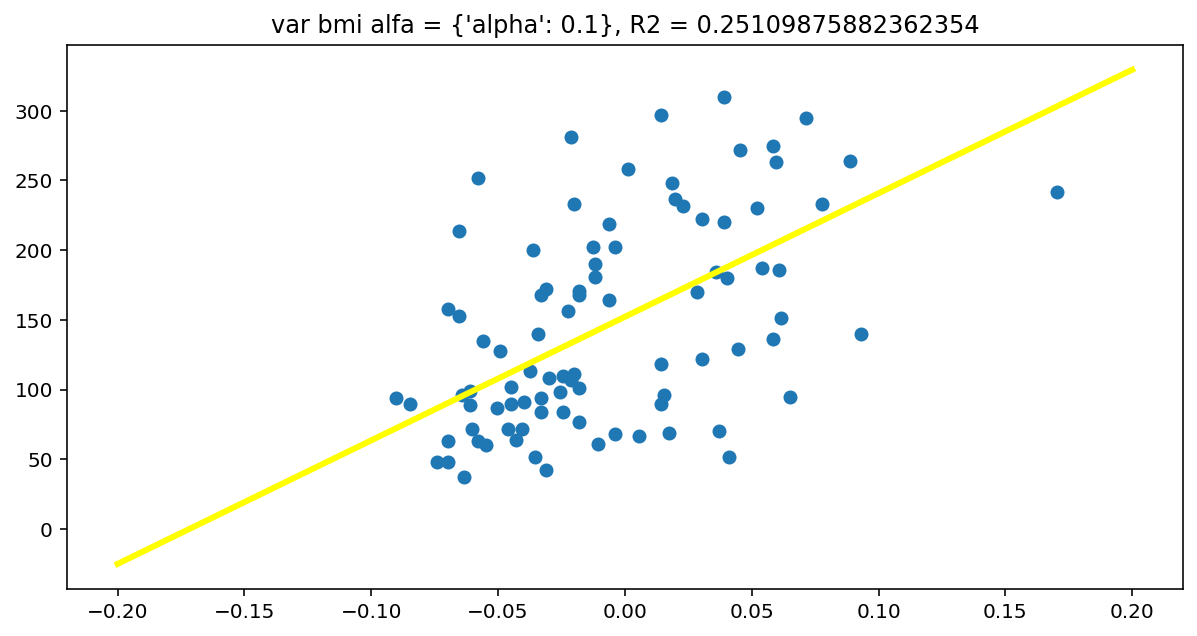

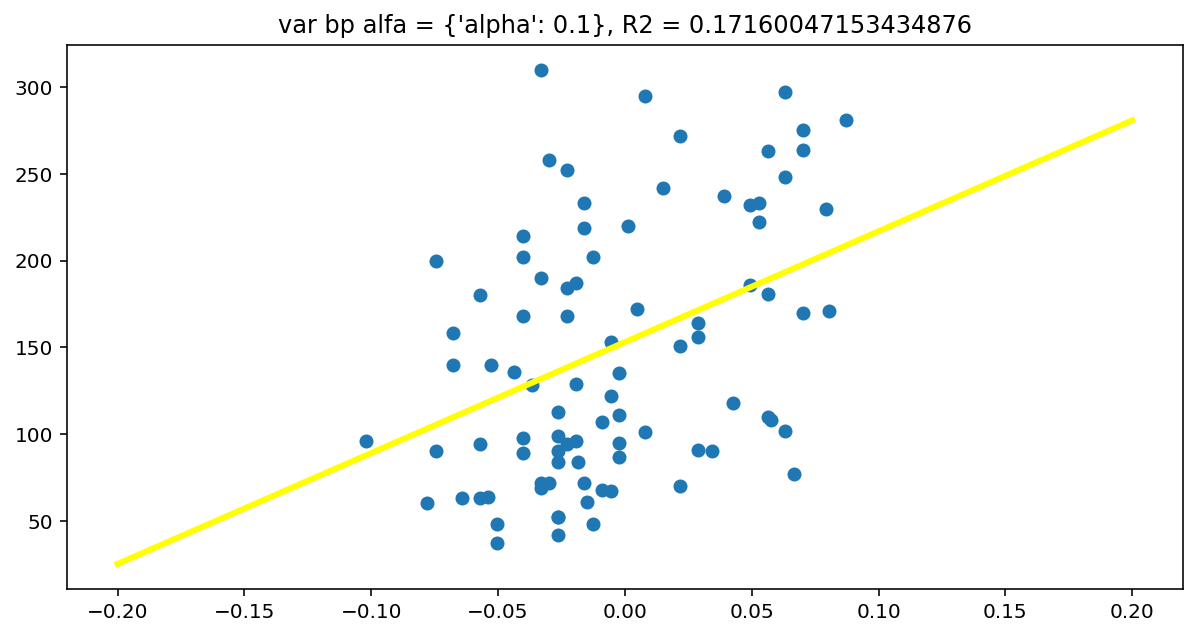

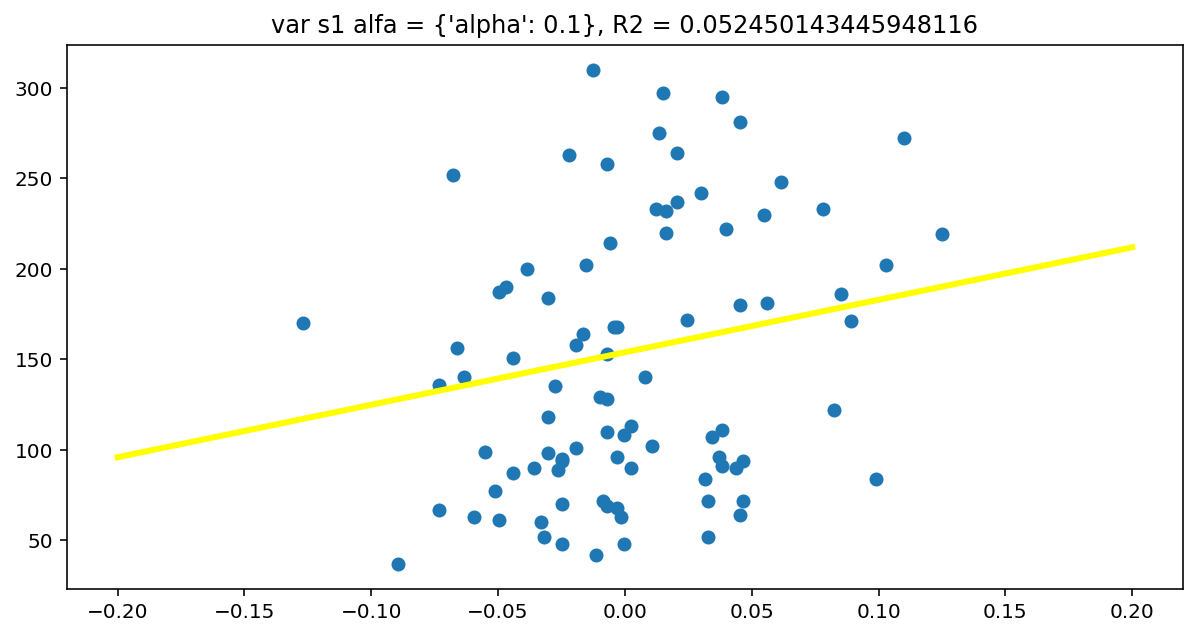

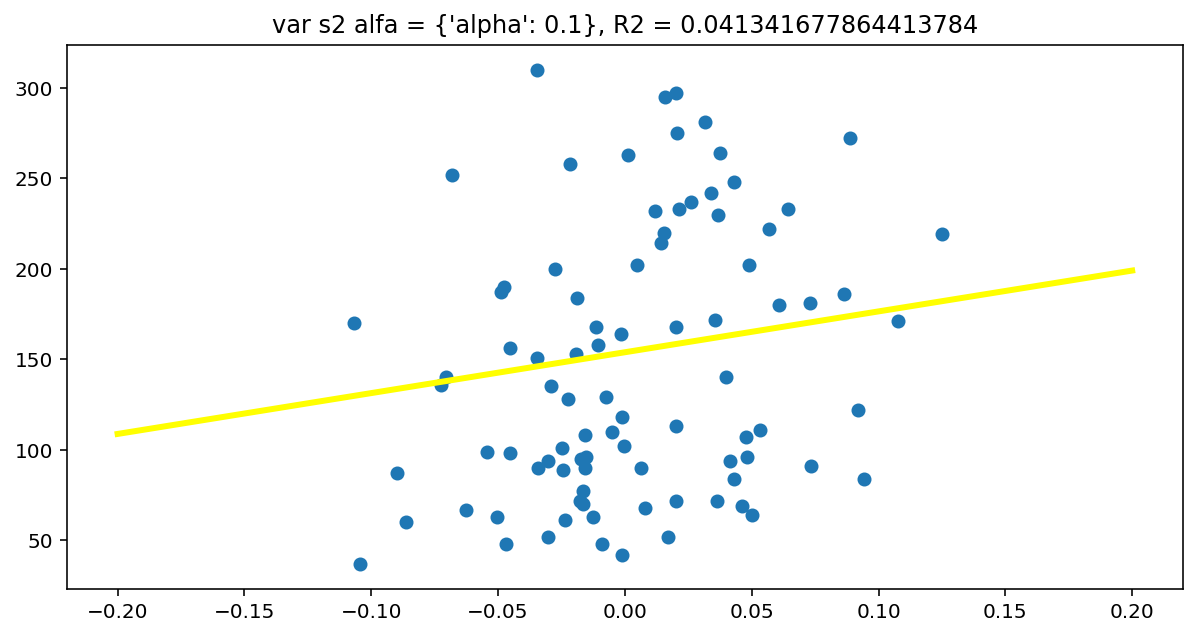

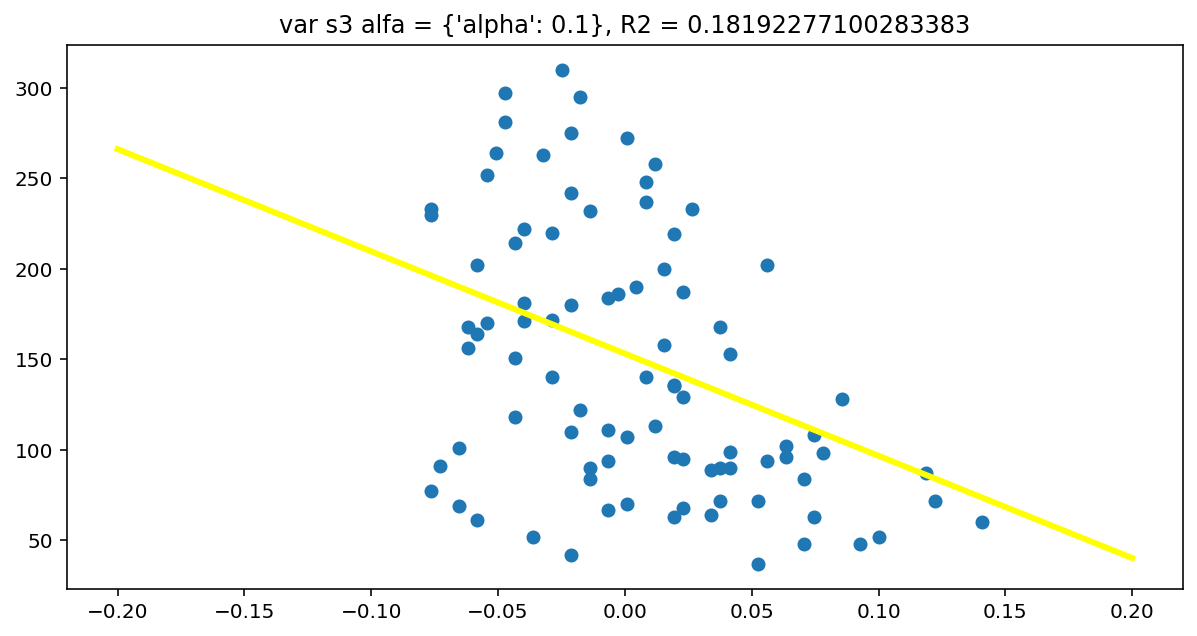

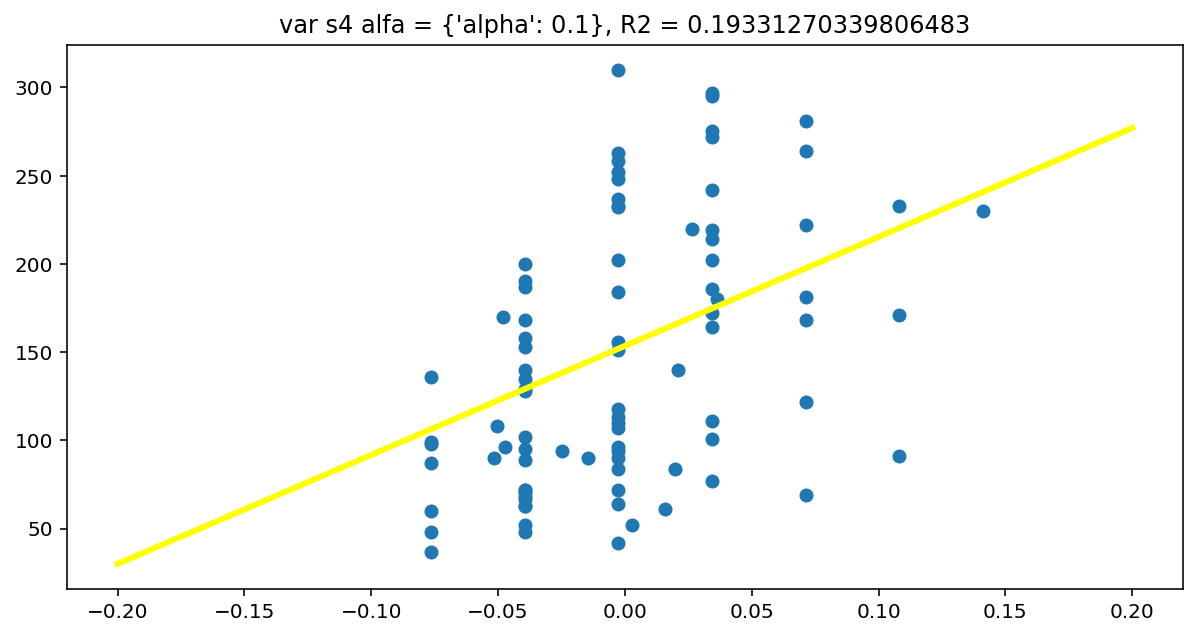

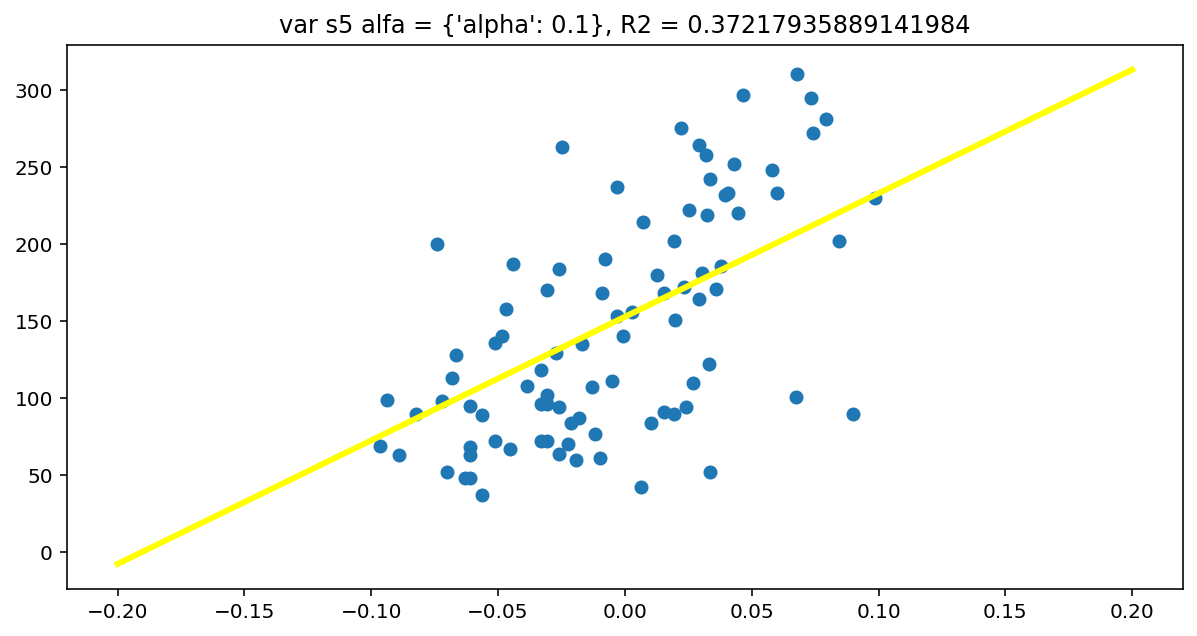

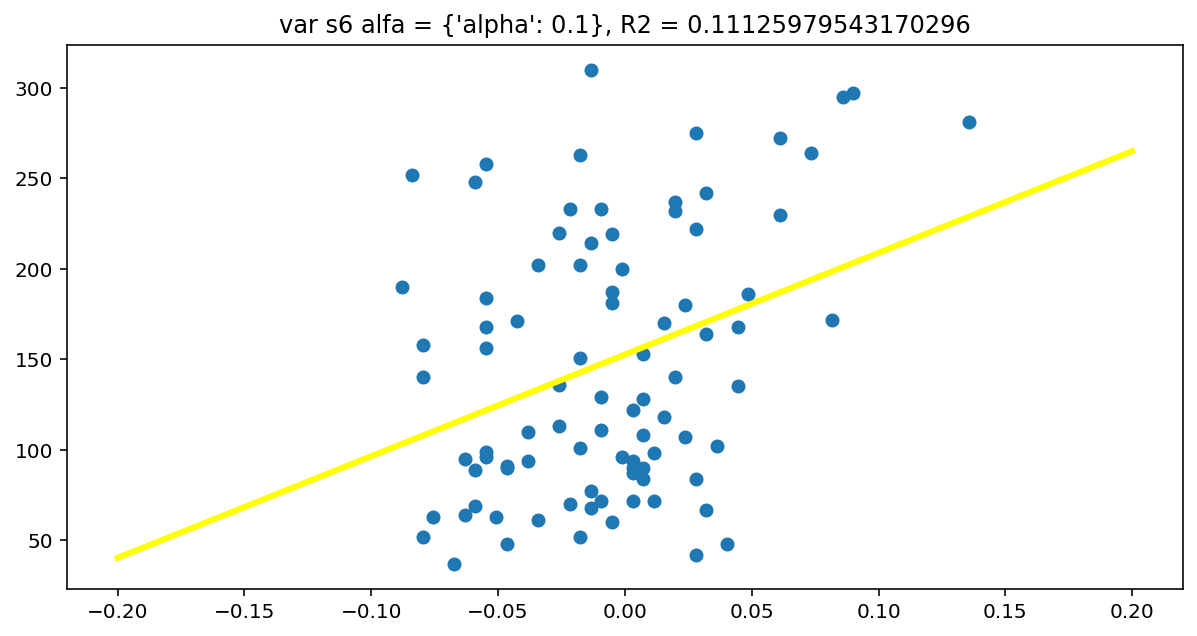

In [ ]:
from sklearn.model_selection import GridSearchCV
alphaValues= {
 'alpha' : [0.001, 0.01, 0.1, 1]
 }
i=0

for i in range(10): #una matriz que contenga en cada iteracion del bucle una de esas variable.
 X_train_tmp = X_train[:,i:i+1]
 X_test_tmp = X_test[:,i:i+1]
 objectRidge = Ridge()
 grid2 = GridSearchCV(objectRidge, alphaValues, cv=10)
 grid2.fit(X_train_tmp, Y_train)
 R2values = grid2.score(X_test_tmp,Y_test)
 BestAlfa = grid2.best_params_
 
 vector_fila = np.linspace(-0.2,0.2, 100)
 vector_columna = np.linspace(-0.2,0.2, 100)
 vector_fila = vector_fila[:,np.newaxis]
 predicted = grid2.predict(vector_fila)
 
 plt.figure(figsize=(10,5))
 plt.title("var %s alfa = %s, R2 = %s" %(feature_names[i], BestAlfa, R2values))
 plt.plot(vector_columna, predicted, color = 'yellow', linewidth = 3)
 plt.scatter(X_test_tmp, Y_test)
 plt.show()



### 2.1.2. Univariate Feature Selection with no linear regression 

Repeat the 1D analysis with Kernel ridge using a RBF kernel. Now, besides `alpha`, cross validate `gamma` using these ranges:
  - `alpha`: 0.001, 0.01, 0.1, 1
  - `gamma` for the RBF kernel: 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1


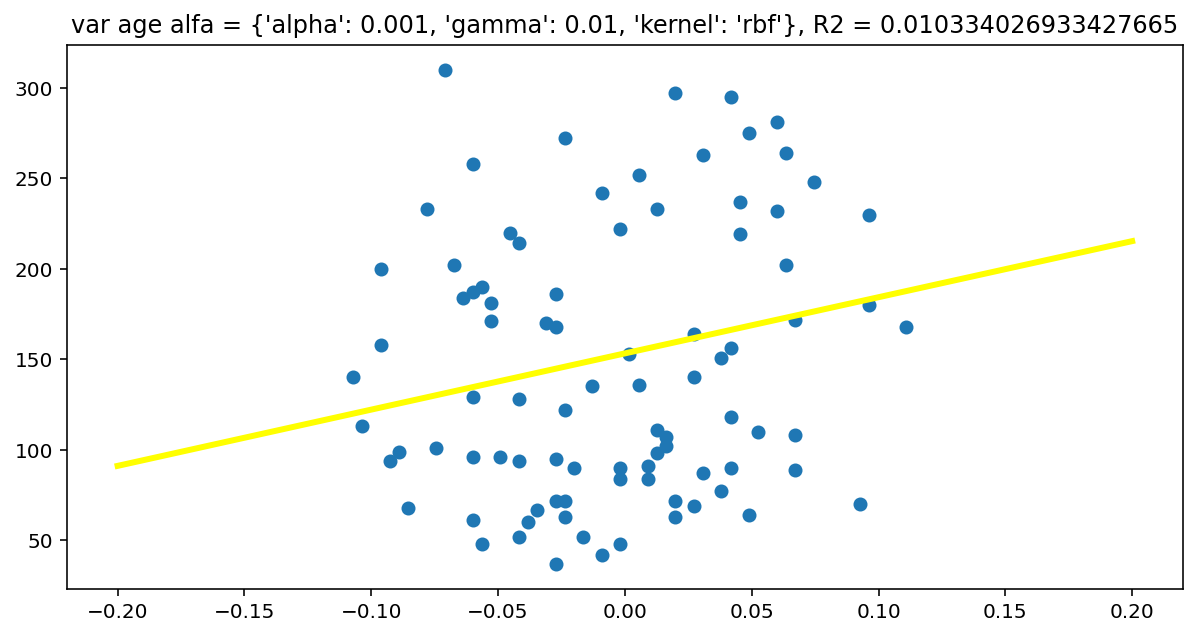

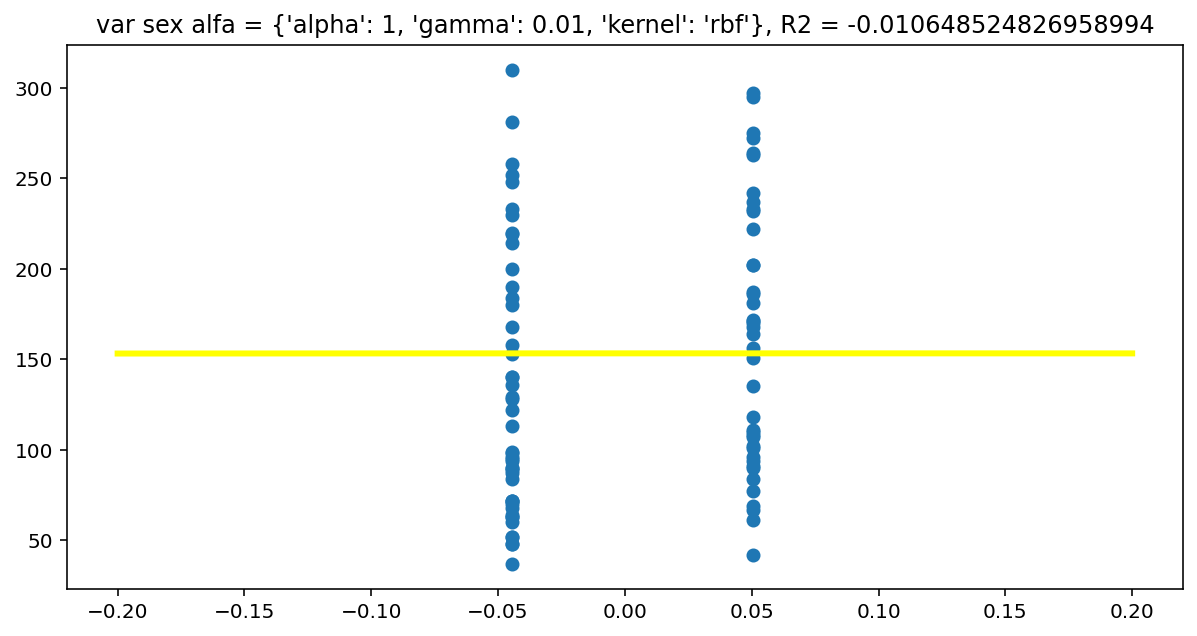

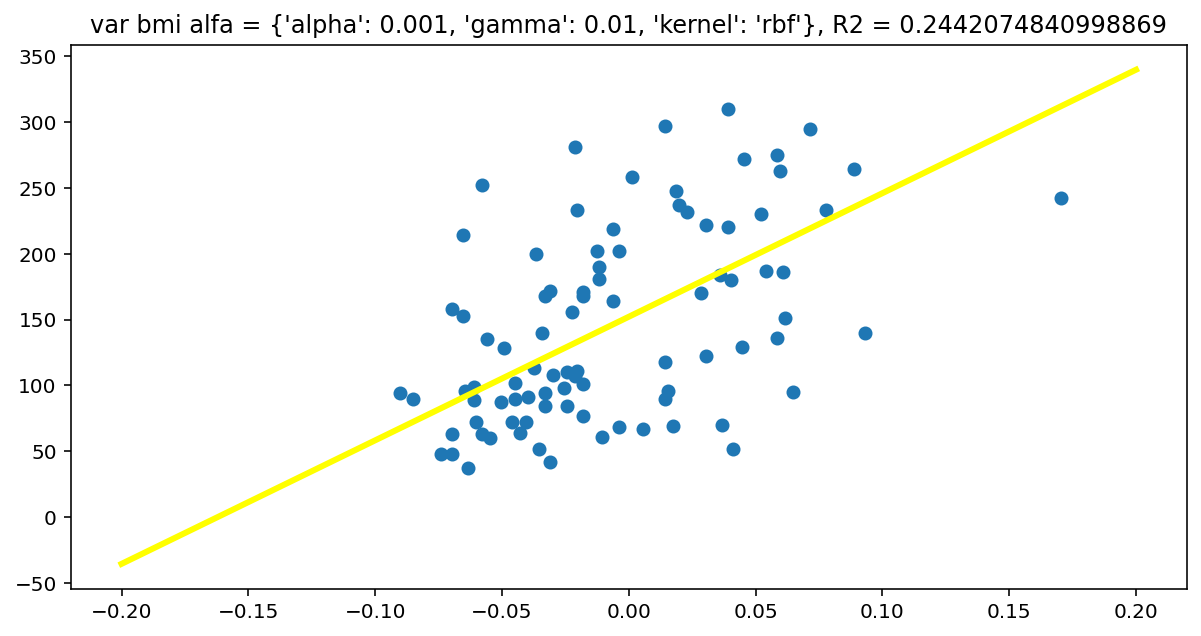

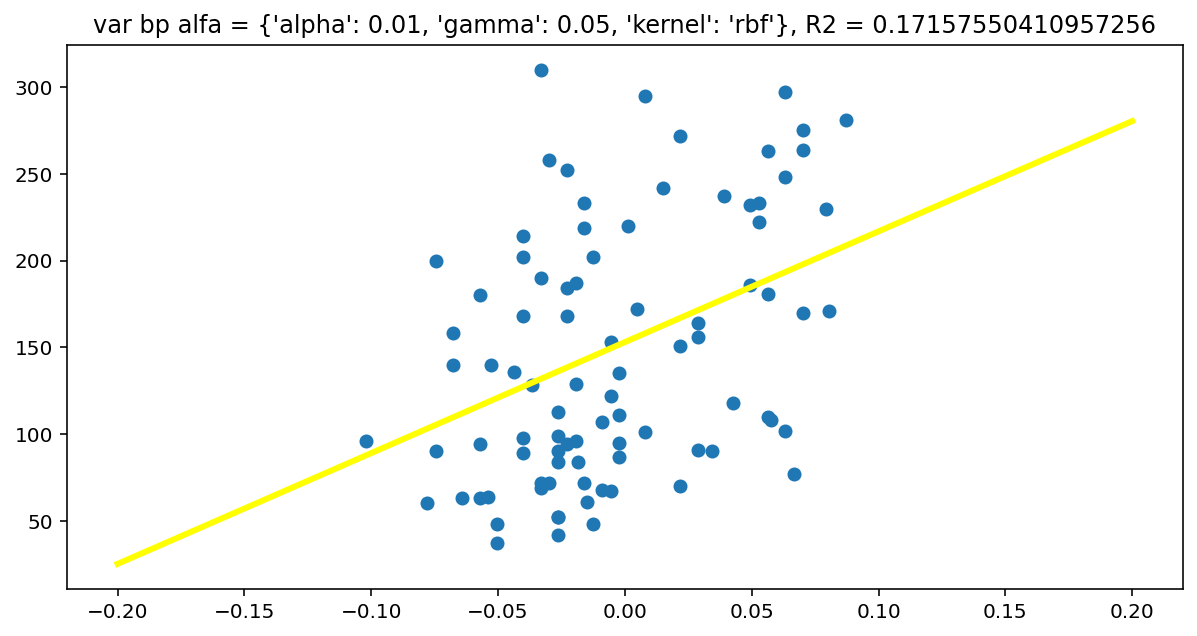

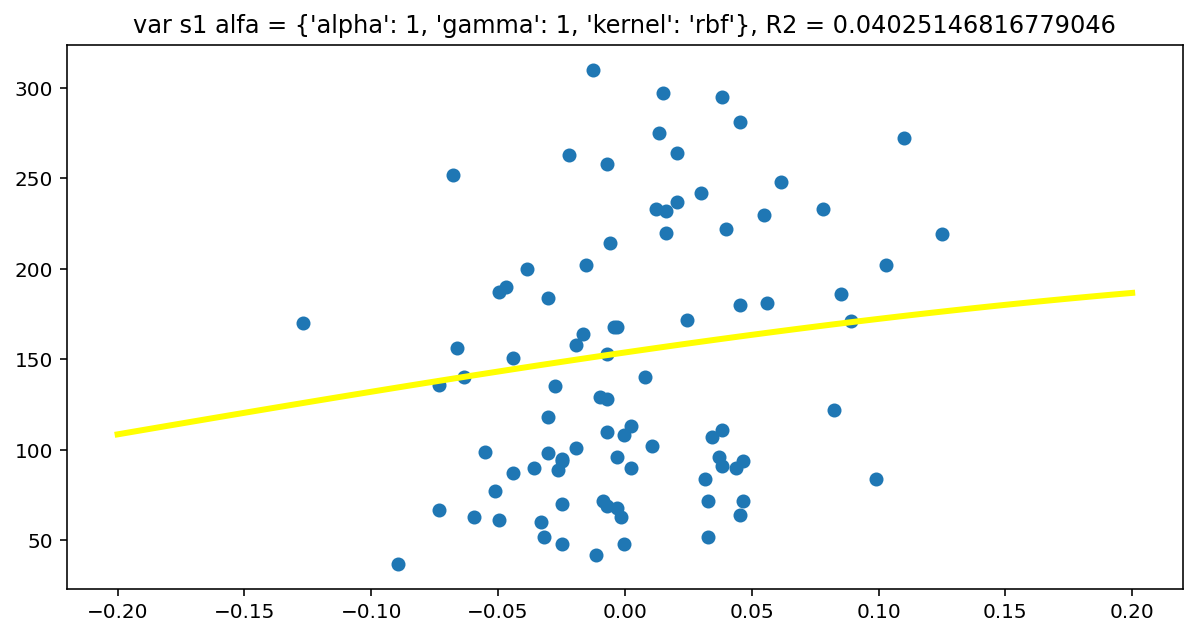

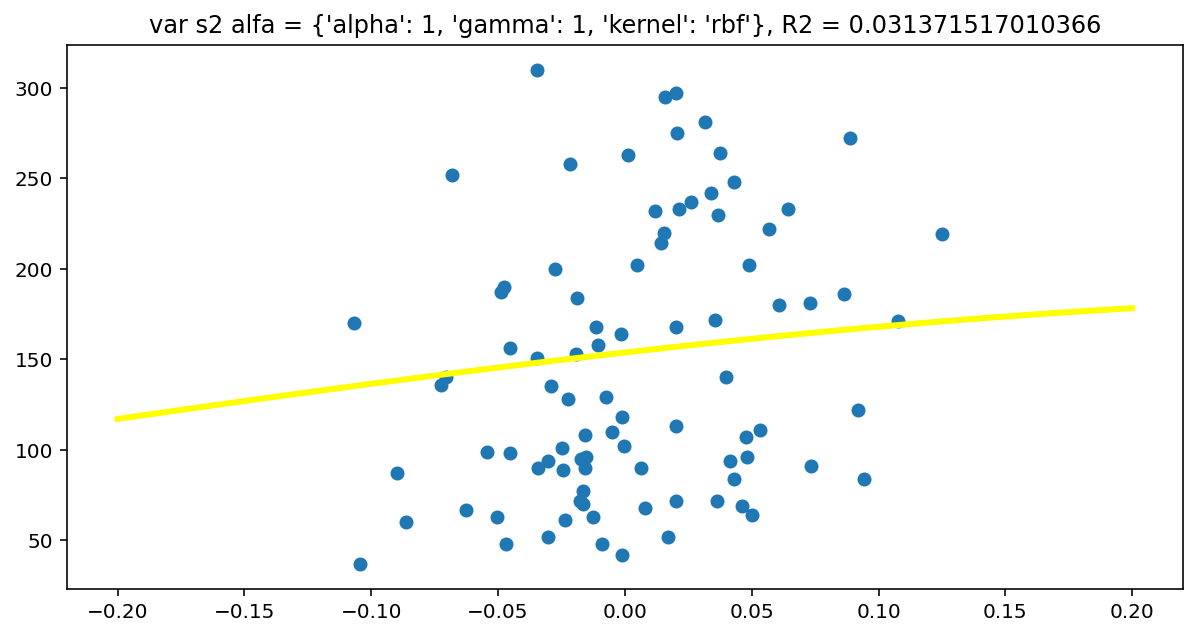

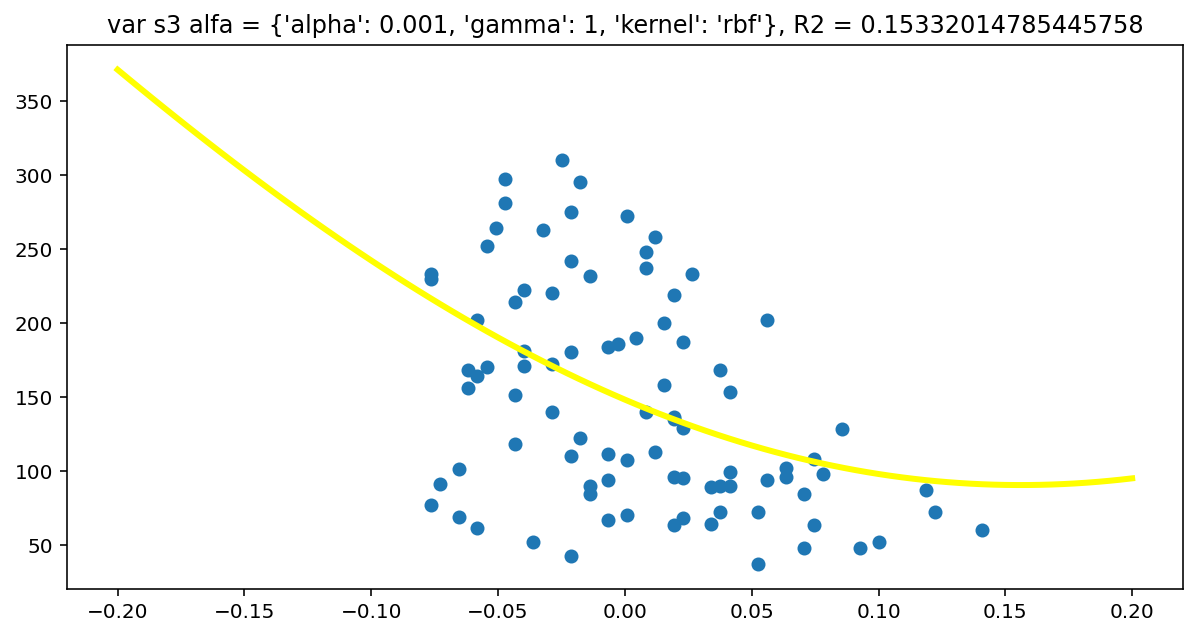

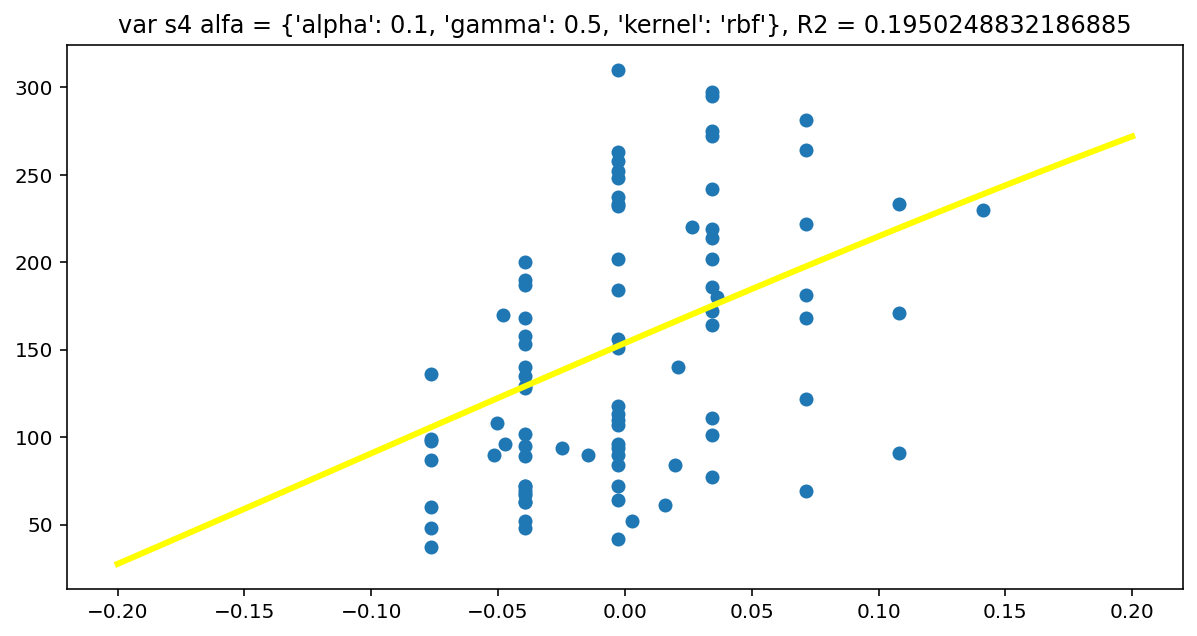

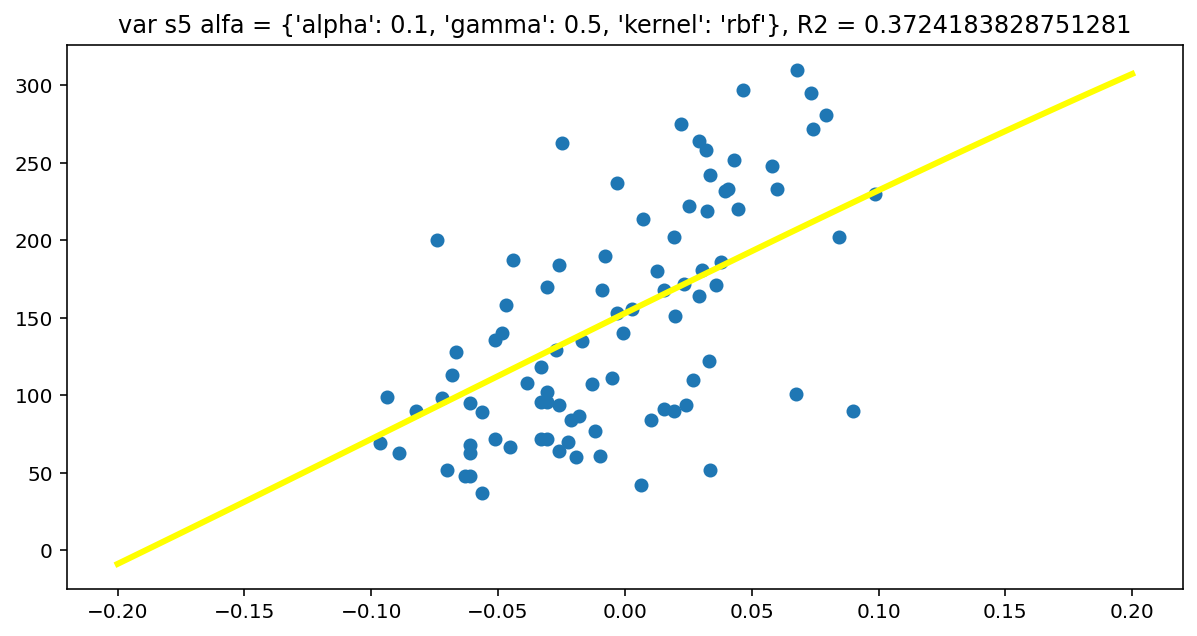

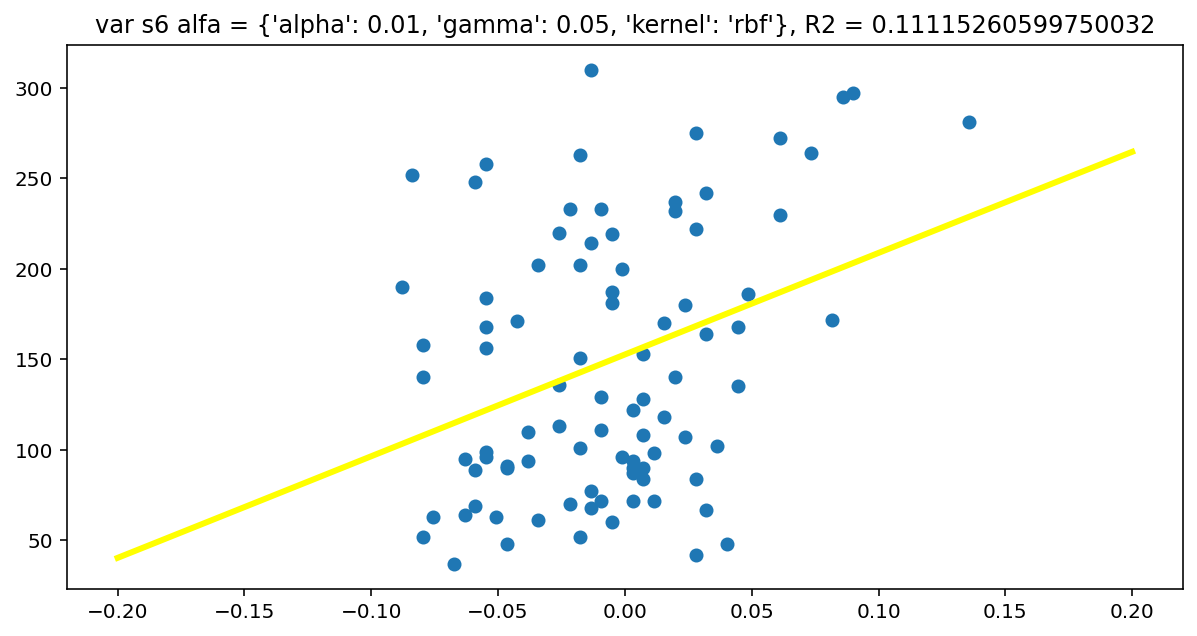

In [ ]:
paramsKRR = {
'alpha' : [0.001, 0.01, 0.1, 1],
'kernel' : ['rbf'],
'gamma' : [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
}
i=0

for i in range(10): #una matriz que contenga en cada iteracion del bucle una de esas variable.
 X_train_tmp = X_train[:,i:i+1]
 X_test_tmp = X_test[:,i:i+1]
 objectRidge = KernelRidge()
 grid2 = GridSearchCV(objectRidge, paramsKRR, cv=10)
 grid2.fit(X_train_tmp, Y_train)
 R2values2 = grid2.score(X_test_tmp,Y_test)
 Bestparams = grid2.best_params_
 vector_fila = np.linspace(-0.2,0.2, 89)
 vector_columna = np.linspace(-0.2,0.2, 89)
 vector_fila = vector_fila[:,np.newaxis]
 predicted = grid2.predict(vector_fila)
 
 plt.figure(figsize=(10,5))
 plt.title("var %s alfa = %s, R2 = %s" %(feature_names[i], Bestparams, R2values2))
 plt.plot(vector_columna, predicted, color = 'yellow', linewidth = 3)
 plt.scatter(X_test_tmp, Y_test)
 plt.show()

# LINEAR:    s5 0.372, bmi 0.251, s4 0.192, s3 0.182, bp 0.171, s6 0.111, s1 0.0524, s2 0.0413, sex -0.010, age 0.0087
# Non-LINEAR: s5 0.372, bmi 0.244, s4 0.195, bp 0.171, s3 0.153, s6 0.111, s1 0.0402, s2 0.0313, sex -0.0106, age 0.0103

# No hay atributos para los cuales el uso de una regresion no lineal haya sido beneficioso. Podemos ver que la mayor diferencia en la linea amarilla de predicción se ve en s3, 
# y empeora su rendimiento con respecto al regresor lineal, siendo además el único que tiene una varianza considerable(en s2 y s3 también se puede observar una predicción curva y también empeora los resultados,
# pero de forma más ligera). Por tanto podemos afirmar que no ha sido rentable utilizar la regresión no-lineal en este caso.

### 2.1.3 Discussion

Was it worth to add the nonlinearity? Is there any variable for which the nonlinear model improves the linear one?

> **LINEAR:    s5 0.372, bmi 0.251, s4 0.192, s3 0.182, bp 0.171, s6 0.111, s1 0.0524, s2 0.0413, sex -0.010, age 0.0087**


> **Non-LINEAR: s5 0.372, bmi 0.244, s4 0.195, bp 0.171, s3 0.153, s6 0.111, s1 0.0402, s2 0.0313, sex -0.0106, age 0.0103**

**No hay atributos para los cuales el uso de una regresion no lineal haya sido beneficioso. Podemos ver que la mayor diferencia en la linea amarilla de predicción se ve en s3, 
y empeora su rendimiento con respecto al regresor lineal, siendo además el único que tiene una varianza considerable(en s2 y s3 también se puede observar una predicción curva y también empeora los resultados, pero de forma más ligera). Por tanto podemos afirmar que no ha sido rentable utilizar la regresión no-lineal en este caso.**

## 2.2. Multivariate Feature Selection: Recursive Feature Selection

After selecting reasonable values for the hyperparameters, you are going to focus on the main goal of this study: Learn which are the most relevant variables to predict the targets.

[Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) is a commonly used framework for this purpose. It basically consists in starting with an estimator fitted with all the variables and recursively withdraw from the training set that variable that achieves a smallest relevance score. In linear regression this score is the absolute value of the weight of that variable in the regressor.

However, a major limitation of the RFE implementation of sklearn is that it only works with those estimators that implement a method to assess the relevance of the variables. 

In this section you are going to code up a version of RFE that uses the crossvalidation error to decide which variable will be removed at each iteration.

The skeleton of the code of the function is the following:

1. Loop that runs $d-1$ times, where $d$ is the number of variables (notice if at each iteration one variable is removed after $d-1$ iterations you only have one surviving variable)

    1.1. Within the $i$-th iteration of the main loop (it means you have removed $i$ variables, therefore there remain $d-i$ variables to explore). Create a `r2_score` empty array with `d-i` positions. Then run another loop for $j=1,\dots, d-i$ iterations:

      1.1.1 Make a copy of your training data and remove one of the remaining $d-i$ features. Name `Z` the $N\times (d-i-1)$ resulting data matrix. If this is the $j$-th iteration of this inner loop, let's consider `Z` results from removing column $j$ of the data matrix (that now has only $d-i$ columns). Assume the $j$ column corresponds to the original variable $v_j$ ($v_j$ is the actual position of column $j$ in the original data matrix $X$ with 10 columns).

      1.1.2. Run a crossvalidation with `Z` and `Y`. Annotate the mean score of the crossvalidation in the $j$-th position of `r2_score`. This is your estimation of the performance when you drop variable $v_j$ (after having droppped the $i$ columns you have already dropped in the previous iterations)

  1.2 Use `r2_score` to decide which is the variable you are dropping in the $i$-th iteration of the main loop. Will it be the position of the maximum or of the minimum in `r2_score`?

  1.3 Drop the corresponding column of the data matrix, now your data matrix has $d-i-1$ columns.


### 2.2.1 Program the grid exploration

Before programming the RFE alogrithm, let us redesign the code of the Section 1.1.1. Now, this function has to cross validate the model parameters, obtain its $R^2$ score over the test data but, additionaly, it has to obtain the average  cross-validated  $R^2$ score of the model for the selected parameters. Check the content of the atributte `best_score_` after fitting the GridSearch object.


In [ ]:
def my_grid2(model, parameters, X_train, Y_train, X_test, Y_test):
  i=0
  for i in range(9):
   grid = GridSearchCV(model(), parameters, cv=10)
   grid.fit(X_train, Y_train)
   r2_value_test = grid.score(X_test, Y_test) 
   r2_value_CV = grid.best_score_
  return grid, r2_value_CV, r2_value_test


  

### 2.2.1 Program the RFE algorithm

In [ ]:

def mi_RFE(model, parameters, X_train, Y_train, X_test, Y_test):
  # Some initializations
  N_tr, num_variables = X_train.shape
  N_test, num_variables = X_test.shape
  remaining_variables = [cc for cc in range(num_variables)]
  removed_variables = []
  score_after_remotion_test = []
  nombres = []
 
  i=0
  
  for i in range(num_variables -1):
    r2_scores_CV = np.zeros(len(remaining_variables))
    r2_scores_test = np.zeros(len(remaining_variables))
    j=0
    for j in range (len(remaining_variables)):
      Z_train = X_train[:,remaining_variables]
      Z_train = np.delete(Z_train,[j],1)
      Z_test = X_test[:,remaining_variables]
      Z_test = np.delete(Z_test,[j],1)
      grid, r2_score_CV, r2_score_test = my_grid2(model, parameters, Z_train, Y_train, Z_test, Y_test)
      r2_scores_CV[j] = r2_score_CV
      r2_scores_test[j] = r2_score_test

    eliminado = np.argmax(r2_scores_CV)
    nombres =  np.append(nombres, feature_names[remaining_variables[eliminado]])
    removed_variables = np.append(removed_variables, remaining_variables[eliminado])
    score_after_remotion_test = np.append(score_after_remotion_test, r2_scores_test[eliminado])
    remaining_variables = np.delete(remaining_variables, eliminado)
    
    

  removed_variables = np.append(removed_variables, remaining_variables[0])
  nombres = np.append(nombres, feature_names[remaining_variables[0]])
  return removed_variables, score_after_remotion_test, nombres


Use the function above to obtain the ranking in which the variables would be removed by the following methods:
- k-NN
- Random Forest
- Ridge Regression
- Kernel Ridge Regression

using the same parameter ranges of Section 1. For the Random Forest algorithm (to speed up the CV process) you can fix the number of trees (`n_estimators`) to 100 and only cross validate `max_leaf_nodes`. Be patient running this code...

In [ ]:

paramskNN = {
    'n_neighbors' :  [1, 3, 5, 7, 10, 15, 20, 40, 80],
    'weights' : ['uniform','distance']
}
removed_variableskNN = []
score_after_remotion_testkNN = []
removed_variableskNN, score_after_remotion_testkNN, nombresKnn = mi_RFE(KNeighborsRegressor, paramskNN, X_train, Y_train, X_test, Y_test)
print("REMOVED FINAL")
print(removed_variableskNN)
print("SCORE FINAL")
print(score_after_remotion_testkNN)
print("NOMBRES")
print(nombresKnn)

# Esenciales: sex, age, s5, bmi
# Ruido: s4*, bp*, s2
# Redundante: s6, s1, s3*

REMOVED FINAL
[9. 7. 4. 1. 6. 3. 5. 0. 8. 2.]
SCORE FINAL
[0.44021451 0.45102708 0.45800284 0.44131881 0.4263499  0.43518622
 0.48188912 0.4645981  0.22791376]
NOMBRES
['s6' 's4' 's1' 'sex' 's3' 'bp' 's2' 'age' 's5' 'bmi']


In [ ]:
paramsRF = {
    'n_estimators' : [100],
    'max_leaf_nodes' : [5, 10, 20, 50] 
}
removed_variablesRF = []
score_after_remotion_testRF = []
removed_variablesRF, score_after_remotion_testRF, nombresRF = mi_RFE(RandomForestRegressor, paramsRF, X_train, Y_train, X_test, Y_test)
print("REMOVED FINAL")
print(removed_variablesRF)
print("SCORE FINAL")
print(score_after_remotion_testRF)
print("NOMBRES")
print(nombresRF)

# Esenciales: bp, s5, bmi
# Ruido: s3
# Redundante: s6, s2, age, s4, sex, s1

REMOVED FINAL
[6. 9. 5. 3. 0. 7. 1. 4. 8. 2.]
SCORE FINAL
[0.47349727 0.46538464 0.46866019 0.44466085 0.44317294 0.44974558
 0.4465216  0.44707542 0.210783  ]
NOMBRES
['s3' 's6' 's2' 'bp' 'age' 's4' 'sex' 's1' 's5' 'bmi']


In [ ]:
paramsRR = {
'alpha' : [0.0001, 0.001, 0.01, 0.1, 1],

}

removed_variablesRR = []
score_after_remotion_testRR = []
removed_variablesRR, score_after_remotion_testRR, nombresRR = mi_RFE(Ridge, paramsRR, X_train, Y_train, X_test, Y_test)
print("REMOVED FINAL")
print(removed_variablesRR)
print("SCORE FINAL")
print(score_after_remotion_testRR)
print("NOMBRES")
print(nombresRR)

# Esenciales: sex, s5, bmi
# Ruido: 
# Redundante: age, s4, s6, s2, s1, s3, bp

REMOVED FINAL
[0. 7. 9. 5. 4. 1. 6. 3. 8. 2.]
SCORE FINAL
[0.46731678 0.47146389 0.46902854 0.46915897 0.47273497 0.45335021
 0.45763864 0.45484005 0.25109876]
NOMBRES
['age' 's4' 's6' 's2' 's1' 'sex' 's3' 'bp' 's5' 'bmi']


In [ ]:
paramsKRR = {
'alpha' : [0.0001, 0.001, 0.01, 0.1, 1],
'kernel' : ['rbf'],
'gamma' : [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
}

removed_variablesKRR = []
score_after_remotion_testKRR = []
removed_variablesKRR, score_after_remotion_testKRR, nombresKRR = mi_RFE(KernelRidge, paramsKRR, X_train, Y_train, X_test, Y_test)
print("REMOVED FINAL")
print(removed_variablesKRR)
print("SCORE FINAL")
print(score_after_remotion_testKRR)
print("NOMBRES")
print(nombresKRR)
0.4613522704926605
# Esenciales: sex, bp, s5, bmi
# Ruido: s1, s3*
# Redundante: age, s4, s6, s2

REMOVED FINAL
[0. 7. 9. 5. 4. 1. 6. 3. 8. 2.]
SCORE FINAL
[0.46761117 0.47166446 0.4691925  0.46930811 0.48948815 0.46143711
 0.47164096 0.4549013  0.24420748]
NOMBRES
['age' 's4' 's6' 's2' 's1' 'sex' 's3' 'bp' 's5' 'bmi']


**Compare the 4 rankings**

Looking at the rankings of the removed variables and the validation scores that the different methods achieve once these variables have been removed, categorize the 10 variables in these three groups:

- **Essential variables**: When one of these variables is removed the performance starts to worsen significantly.
- **Noisy variables**: Removing these variables makes the performance better
- **Redundant variables**: These variables can be removed without affecting the performance, as with high probability the information that they carry is also present in other variables.

**Justify your answer**

Teniendo en cuenta la clasificacion de los atributos en los 4 modelos, la clasificación más común es:

**Esenciales**: s5, bmi (todas), sex (3/4), bp(2/4)

**Ruido**: s3

**Redundante**: age, s4, s6, s2, s1



# 3. Role of each variable in the model

Besides the importance of each variable in the prediction of the targets evaluated in Section 2, some of the models enable to analize the role of each variable within the predictive function $f(\mathbf x)$.



## 3.1. Linear regression case
In the linear regression case
$$
f(\mathbf x) = \mathbf w^\top \mathbf x + w_0 = w_0 + \sum_{k=1}^d w_kx_k
$$each variable $x_k$ contribution to the predictive function is its value multiplied by the weight $w_k$.

**Relate the value of $w_k$ with the relevance of $x_k$**.

Retrieve the weights of the `best_estimator_` for the ridge regressor in Section 1.1 and compare this relevance of the variables based on these weights with the ranking of variables found in Section 2.2 (for the Ridge ression model).

Hint: Think about the sign and the absolute value of $w_k$.

In [ ]:
pesosRidge = gridRR.best_estimator_.coef_ #Gridsearch de ridge regression
print("El valor original de cada peso %s" %pesosRidge)
print()
pesosRidge = abs(pesosRidge)
i=0
for i in range (10):
  print("La variable %s tiene una relevancia de %s" %(feature_names[i] , pesosRidge[i]))

#Section 2
#[age, s4, s6, s2, s1, sex, s3, bp, s5, bmi]
#Section 3
#[age, s6, s2, s1, s4, s3, sex, bp, s5, bmi]

El valor original de cada peso [  42.85374471 -205.49571833  505.08633402  317.09877365 -108.49829825
  -86.2387599  -190.36567438  151.7067317   392.28728164   79.90836219]

La variable age tiene una relevancia de 42.853744706941185
La variable sex tiene una relevancia de 205.49571833015813
La variable bmi tiene una relevancia de 505.08633402034786
La variable bp tiene una relevancia de 317.0987736516991
La variable s1 tiene una relevancia de 108.4982982521636
La variable s2 tiene una relevancia de 86.23875989698416
La variable s3 tiene una relevancia de 190.36567438363303
La variable s4 tiene una relevancia de 151.70673169925894
La variable s5 tiene una relevancia de 392.287281637796
La variable s6 tiene una relevancia de 79.90836219282711


**Include your discussion here!**

BMI, s5 y bp son las más relevantes(tienen los mayores pesos) siendo bmi la más importante de todas.
sex y s3 difieren muy poco por lo que es normal que esten cambiados.

Lo mismo con los valores s2, s1, s4 y s6

Age es el menos relevante en los dos casos.

## 3.2 Decision Tree

Plot a decision tree with the code of the lecture notebook and interpret the relevance of the variables. 

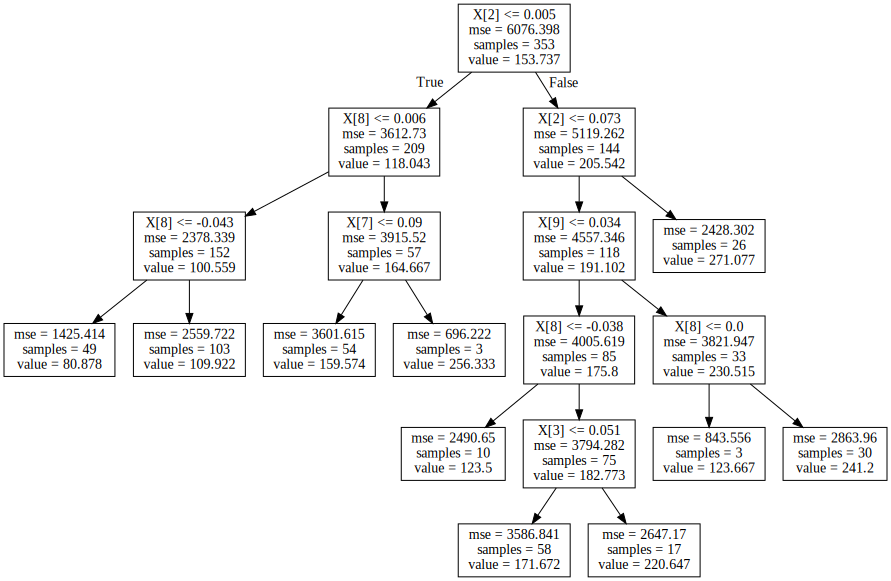

In [ ]:
from sklearn import tree
import graphviz

DT = tree.DecisionTreeRegressor(max_leaf_nodes = 10)
DT = DT.fit(X_train, Y_train)
arbol = tree.export_graphviz(DT)
graph = graphviz.Source(arbol) 
graph

**Include your discussion here!**

Se puede ver que el más importante, al igual que en el resto de modelos es BMI.
Además el siguiente más importante también s5 igual que siempre.

Aparecen además s4, s6 y bp que son variable influyentes pero no tanto como las otras dos. YFinalmente, las variables que no aparecen se podría considerar redundantes o irrelevantes.

## 3.3. Random Forest

In Random Forest the variables are individually selected to design the stump test in each branch node of each tree in the forest. Relevant variables will be in general oftenly selected for these tests, while noisy or redundant variables will be selected less oftenly.  Besides, since the growing of each tree only considers a subset of the training data, the left-out subset can be used as validation set to evaluate the quality of each stump. In this sense, the most relevant variables will lead to better quality stumps.

In the sklearn implementation of Random Forest there is a property `feature_importances_` that is precisely a score in the relevance of the features.

**Retrieve the weights of the `best_estimator_` for the random forest in Section 1.1 and compare this relevance score  with the ranking of variables found in Section 2.2.**

In [ ]:
 pesosRF= gridRF.best_estimator_.feature_importances_

j=0
for j in range (10):
  print("La variable %s tiene una relevancia de %s" %(feature_names[j] , pesosRF[j]))

#section 2
  #[s3, s6, s2, bp, age, s4, sex, s1, s5, bmi]
#section3
  #[sex, s4, s1, s2, age, s3, s6, bp, s5, bmi]

La variable age tiene una relevancia de 0.03745707154369425
La variable sex tiene una relevancia de 0.004627215796801346
La variable bmi tiene una relevancia de 0.4476253836279288
La variable bp tiene una relevancia de 0.08748629136990557
La variable s1 tiene una relevancia de 0.03110294977351872
La variable s2 tiene una relevancia de 0.03716832068273015
La variable s3 tiene una relevancia de 0.04039565630025227
La variable s4 tiene una relevancia de 0.018511518944129626
La variable s5 tiene una relevancia de 0.24357418325856353
La variable s6 tiene una relevancia de 0.05205140870247574


Discussion:

**BMI y s5 son los mejores atributos en ambos casos. Para el resto como son todos valores < 10^-2 ordenarlos resulta my díficil, debido a la poca diferencia de relevancia que hay entre ellos.**
